# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

## Download and prepare the data for processing

In [2]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

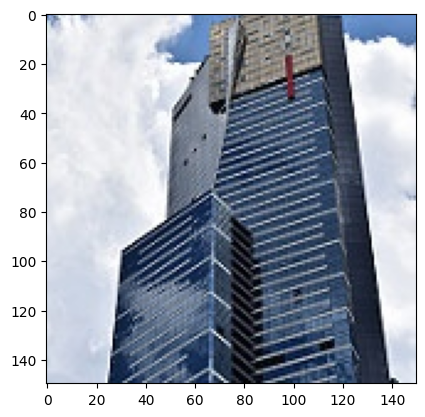

In [3]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Transformations

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.filenames = []
        self.labels = []
        self.class_names = []
        
        # Traverse the directory structure
        for root, dirs, files in os.walk(data_dir):
            # Get the class name based on the folder name
            class_name = os.path.basename(root)
            
            if len(files) > 0:
                # Append all file paths and assign labels based on folder name
                for filename in files:
                    if filename.endswith('.jpg'):
                        self.filenames.append(os.path.join(root, filename))
                        # Use the class name (parent folder name) as the label
                        if class_name not in self.class_names:
                            self.class_names.append(class_name)
                        label = self.class_names.index(class_name)
                        self.labels.append(label)
                        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_path = self.filenames[idx]
        image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
resize_size = 150

transform_train = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = ImageDataset(train, transform_train)
test_dataset = ImageDataset(test, transform)
val_dataset = ImageDataset(pred, transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

### Display image examples

In [8]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

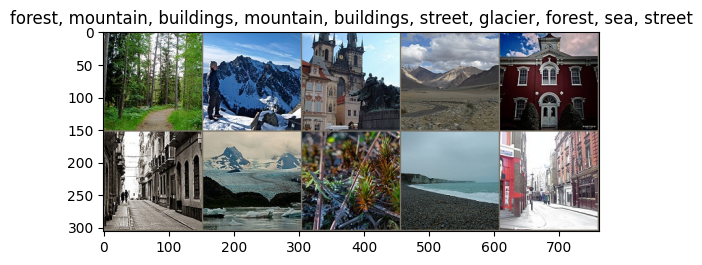

In [9]:
imshow(make_grid(images[:10], nrow=5), labels[:10], test_dataset.class_names)

### Insights about the classes

In [10]:
print(f"Amount of classes: {len(test_dataset.class_names)}")
print(f"Classes: {test_dataset.class_names}")
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.class_names}
for label in train_dataset.labels:
    class_counts[train_dataset.class_names[label]]+=1

print("\nDistribution of classes in the training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Amount of classes: 6
Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Size of training dataset: 14034
Size of test dataset: 3000
Size of validation dataset: 7301

Distribution of classes in the training dataset:
mountain: 2512
street: 2382
buildings: 2191
sea: 2274
forest: 2271
glacier: 2404


## Develop the architecture for a convolutional neural network (CNN) for image classification

## Train the model on the training dataset

## Analyze the effectiveness of the model using the valid and test datasets

## Analyze the results and proposal of further potential improvements of the model